In [1]:

import os, sys
print('python version:',sys.version)
import pandas as pd
print('pandas version:',pd.__version__)
import openpyxl
print('openpyxl version:',openpyxl.__version__)

import os
import numpy as np
print('numpy version:',np.__version__)

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib version:', matplotlib.__version__)
import scipy
import scipy.stats as stats
print('scipy version:',scipy.__version__)
from scipy.stats import norm, skew, kurtosis
from sklearn.utils import resample
print('sklearn version:',sys.modules['sklearn'].__version__)

python version: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.3.5
openpyxl version: 3.1.3
numpy version: 1.21.6
matplotlib version: 3.5.3
scipy version: 1.7.3
sklearn version: 1.0.2


Setting up the enviornment

In [2]:
### this cell separates the subjects and session of the frame displacement data
abspath = os.path.abspath('__file__')
dname = os.path.dirname(os.path.dirname(abspath))
os.environ["ROOTDIR"] = dname  # seth path
rootdir = os.environ["ROOTDIR"]
metadata_path = os.path.join(rootdir, 'metadata')

Reading the subjects in the first wave

In [3]:
data = pd.read_csv(os.path.join(metadata_path,'sub_list_fd.csv'))
## solitting the file name to sub ses func and 
sub_ses_df = data['file_name'].str.split('/', expand=True).drop([0,1,2,3,4,5,8,9],axis=1)
## remove the file name of the actual data remaining the fd checking axis =1 means collunm
fd_df = data.drop(['file_name'],axis=1)
#concatenating the final data
fd_data = pd.concat([sub_ses_df,fd_df],axis=1)
fd_data = fd_data.rename(columns={6:'sub_id' , 7:'session'})
fd_data.drop(fd_data[fd_data.session == 'ses-3'].index, inplace=True)
fd_data.drop(fd_data[fd_data.session == 'ses-2'].index, inplace=True)
fd_data = fd_data.sort_values("sub_id") 

###### IMPORTANT: here false is optimal in both conditions

In [4]:
#READING THE DATA
confund_data = pd.read_csv(os.path.join(metadata_path, 'checaCONFOUNDS.txt'), sep= " ")
sub_ids = pd.read_csv(os.path.join(metadata_path, 'subjects.txt'),sep=' ')
#remove the unnecessary file names and indexes
sub_ids = sub_ids['FILE_NAME'].str.split('/', expand=True).drop([2,3],axis=1)
confund_data = confund_data.drop(['index','V2'], axis=1)

conf_sub_data = pd.concat([sub_ids, confund_data['V1']==181], axis=1)
conf_sub_data = conf_sub_data.rename({0 : 'sub_id', 1:'session'}, axis=1)
#dopping other sessions / wave
conf_sub_data.drop(conf_sub_data[conf_sub_data.session == 'ses-3'].index, inplace=True)
conf_sub_data.drop(conf_sub_data[conf_sub_data.session == 'ses-2'].index, inplace=True)
conf_sub_data

,sub_id,session,V1
0,sub-00003,ses-1,True
2,sub-00008,ses-1,True
3,sub-00015,ses-1,True
4,sub-00016,ses-1,True
7,sub-00019,ses-1,True
...,...,...,...
1514,sub-02496,ses-1,True
1519,sub-02502,ses-1,True
1522,sub-02507,ses-1,True
1523,sub-02509,ses-1,True


In [5]:
df2 = pd.merge(fd_data, conf_sub_data, on=['sub_id','session'])
df2 = df2.drop(['session'], axis=1)
# min max mean of df2 summary
df2.describe()

,fd_mean_value,fd_count_high_value
count,668.000000,668.000000
mean,0.217819,28.170659
std,0.256745,30.606428
min,0.053471,1.000000
25%,0.104317,6.000000
50%,0.143898,17.000000
75%,0.221739,40.000000
max,2.769558,173.000000


Uploading sociodemografic and psicometric data and doing random sample imputation for the missing data

In [6]:
#Reading the data
socidemo_path = os.path.join(rootdir,'fMRI_INPD_sociodemographic')
socio_psi = pd.read_excel(os.path.join(socidemo_path,'banco_angelo.xlsx'))

dados_clinicos = socio_psi[['ident', 'gender', 'abepscore', 'age', 'DQ','subjectid', 'cape_tot', 'cape_PA_score', 'cape_PI_score', 'cape_BE_score']]
print(dados_clinicos.info())

# renaming the subject ids
for index in dados_clinicos['ident']:  
    dados_clinicos['ident'] = dados_clinicos['ident'].replace(index, 'sub-{}'.format(str(index).zfill(5)))
dados_clinicos = dados_clinicos.rename(columns={'ident':'sub_id'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ident          2511 non-null   int64  
 1   gender         2511 non-null   int64  
 2   abepscore      2511 non-null   int64  
 3   age            2511 non-null   float64
 4   DQ             2241 non-null   float64
 5   subjectid      2511 non-null   int64  
 6   cape_tot       2249 non-null   float64
 7   cape_PA_score  2249 non-null   float64
 8   cape_PI_score  2249 non-null   float64
 9   cape_BE_score  2243 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 196.3 KB
None


c:\Users\angel\Documents\masters-uploaded-github\INPD-neuroimage-cape\.venv-CAPE-neuroimag\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


merging neuroimage masures to psicometric and sociodemo dataframes and removing images with substantial problems

Removing subjects due to exclusion criteria

In [7]:
df_inicial = pd.merge(dados_clinicos, df2, on=['sub_id'])

# identifying the site of colection
df_inicial['subjectid'] = np.floor(df_inicial['subjectid']/10000)
df_inicial.rename(columns={'subjectid':'colection_site'}, inplace=True)

# this removes images that dont have 181 time points in the fmri, wich is the normal Time Series lenght
df_final = df_inicial.query('V1 == True')
# dropping subjects that dont have cape_tot value
df_final = df_final[df_final['cape_tot'].notna()]

print(df_inicial.shape[0])
print(df_final.shape[0])
print(df_final.info())

668
663
<class 'pandas.core.frame.DataFrame'>
Int64Index: 663 entries, 0 to 667
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sub_id               663 non-null    object 
 1   gender               663 non-null    int64  
 2   abepscore            663 non-null    int64  
 3   age                  663 non-null    float64
 4   DQ                   662 non-null    float64
 5   colection_site       663 non-null    float64
 6   cape_tot             663 non-null    float64
 7   cape_PA_score        663 non-null    float64
 8   cape_PI_score        663 non-null    float64
 9   cape_BE_score        663 non-null    float64
 10  fd_mean              663 non-null    bool   
 11  fd_mean_value        663 non-null    float64
 12  fd_count_high        663 non-null    bool   
 13  fd_count_high_value  663 non-null    int64  
 14  V1                   663 non-null    bool   
dtypes: bool(3), float64(8), int64(3)

In [8]:
# ramdom sample
def random_sample_imputation(df):
   
    cols_with_missing_values = [col for col in df.columns[df.isna().any()] if col != 'cape_tot']

    for var in cols_with_missing_values:

        # extract a random sample
        random_sample_df = df[var].dropna().sample(df[var].isnull().sum(),
                                                    random_state=0, replace=True)
        # re-index the randomly extracted sample
        random_sample_df.index = df[
                df[var].isnull()].index

        # replace the NA
        df.loc[df[var].isnull(), var] = random_sample_df
    
    return df

df_final = random_sample_imputation(df_final)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663 entries, 0 to 667
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sub_id               663 non-null    object 
 1   gender               663 non-null    int64  
 2   abepscore            663 non-null    int64  
 3   age                  663 non-null    float64
 4   DQ                   663 non-null    float64
 5   colection_site       663 non-null    float64
 6   cape_tot             663 non-null    float64
 7   cape_PA_score        663 non-null    float64
 8   cape_PI_score        663 non-null    float64
 9   cape_BE_score        663 non-null    float64
 10  fd_mean              663 non-null    bool   
 11  fd_mean_value        663 non-null    float64
 12  fd_count_high        663 non-null    bool   
 13  fd_count_high_value  663 non-null    int64  
 14  V1                   663 non-null    bool   
dtypes: bool(3), float64(8), int64(3), object

In [9]:
# dealing with manual inspection 
# Open the file and read the content
with open(os.path.join(metadata_path,'subid_imagem-ruim.txt'), 'r') as file:
    content = file.read()

# Split based on commas (or any other delimiter)
variables = content.split(' ')  # Adjust the delimiter as needed

# Remover entradas vazias, caso existam
variables = [s for s in variables if s]

# Criar uma lista de listas fazendo o split
split_data = [s.split('_') for s in variables]

# Criar o DataFrame com base nos resultados do split
manIsnpec = pd.DataFrame(split_data, columns=['sub_id', 'session', 'func', 'sub_id_2', 'session_2', 'task', 'run', 'space', 'resolution', 'description', 'new'])

# Organizing the dataset for only selecting impartant features, such as w0 images aka ses-1
manIsnpec = manIsnpec.drop(['func', 'sub_id_2', 'session_2', 'task', 'run', 'space', 'resolution', 'description', 'new'], axis=1)
manIsnpec = manIsnpec.query('session == "ses-1"')

#remove the subjects due to manual inspection criteria
df_final = df_final[~df_final['sub_id'].isin(manIsnpec['sub_id'])]

print(df_final.shape[0])
df_final.head()

602


,sub_id,gender,abepscore,age,DQ,colection_site,cape_tot,cape_PA_score,cape_PI_score,cape_BE_score,fd_mean,fd_mean_value,fd_count_high,fd_count_high_value,V1
0,sub-00003,2,10,8.361396,94.0,1.0,1.0,0.0,1.0,0.0,False,0.072094,False,3,True
1,sub-00008,1,16,12.569473,76.0,1.0,7.0,0.0,2.0,2.0,True,0.311252,True,51,True
2,sub-00015,2,19,12.221766,85.0,1.0,5.0,0.0,4.0,0.0,False,0.118437,False,3,True
3,sub-00016,1,10,11.619439,100.0,1.0,1.0,0.0,1.0,0.0,True,0.587256,True,101,True
4,sub-00019,2,13,11.049966,75.0,1.0,4.0,0.0,2.0,0.0,False,0.129256,False,17,True


In [10]:
# dropping the subjects that have to be removed by qualy control of images
threshold_fdmean, threshold_DQ = 0.35, 70
# removing subjects with IQ < 70 is mandatory. Less than it subject may not even understand the test.
df_final = df_final.query(f'DQ >= {threshold_DQ}')
print(df_final.shape[0])

df_final_fdmean = df_final.query(f'fd_mean<={threshold_fdmean}')
print(df_final_fdmean.shape[0])

#excluding the subjects that have to be manually inspected
# df_final_maninspect = df_final[df_final['session'].isnull()]
# print('manIsnpec',df_final_maninspect.shape[0])

df_final_final = df_final.query(f'fd_mean<={threshold_fdmean} and DQ >= {threshold_DQ}')
print('after quality criteria sample size ',df_final_final.shape[0])
# df_final_final = df_final_final[df_final_final['session'].isnull()]
df_final_final = df_final_final.drop(['fd_mean', 'fd_count_high', 'V1', 'DQ'], axis=1)

# stablising df_inincial to have the same variabels to df_final_final
# df_inicial = df_inicial.drop(['fd_mean', 'fd_mean_value', 'fd_count_high', 'V1', 'DQ'], axis=1)
df_inicial = df_inicial.drop([col for col in df_inicial.columns.to_list() if not( col in df_final_final.columns.to_list())],axis=1)

593
420
after quality criteria sample size  420


# comparing the databases after exclusion

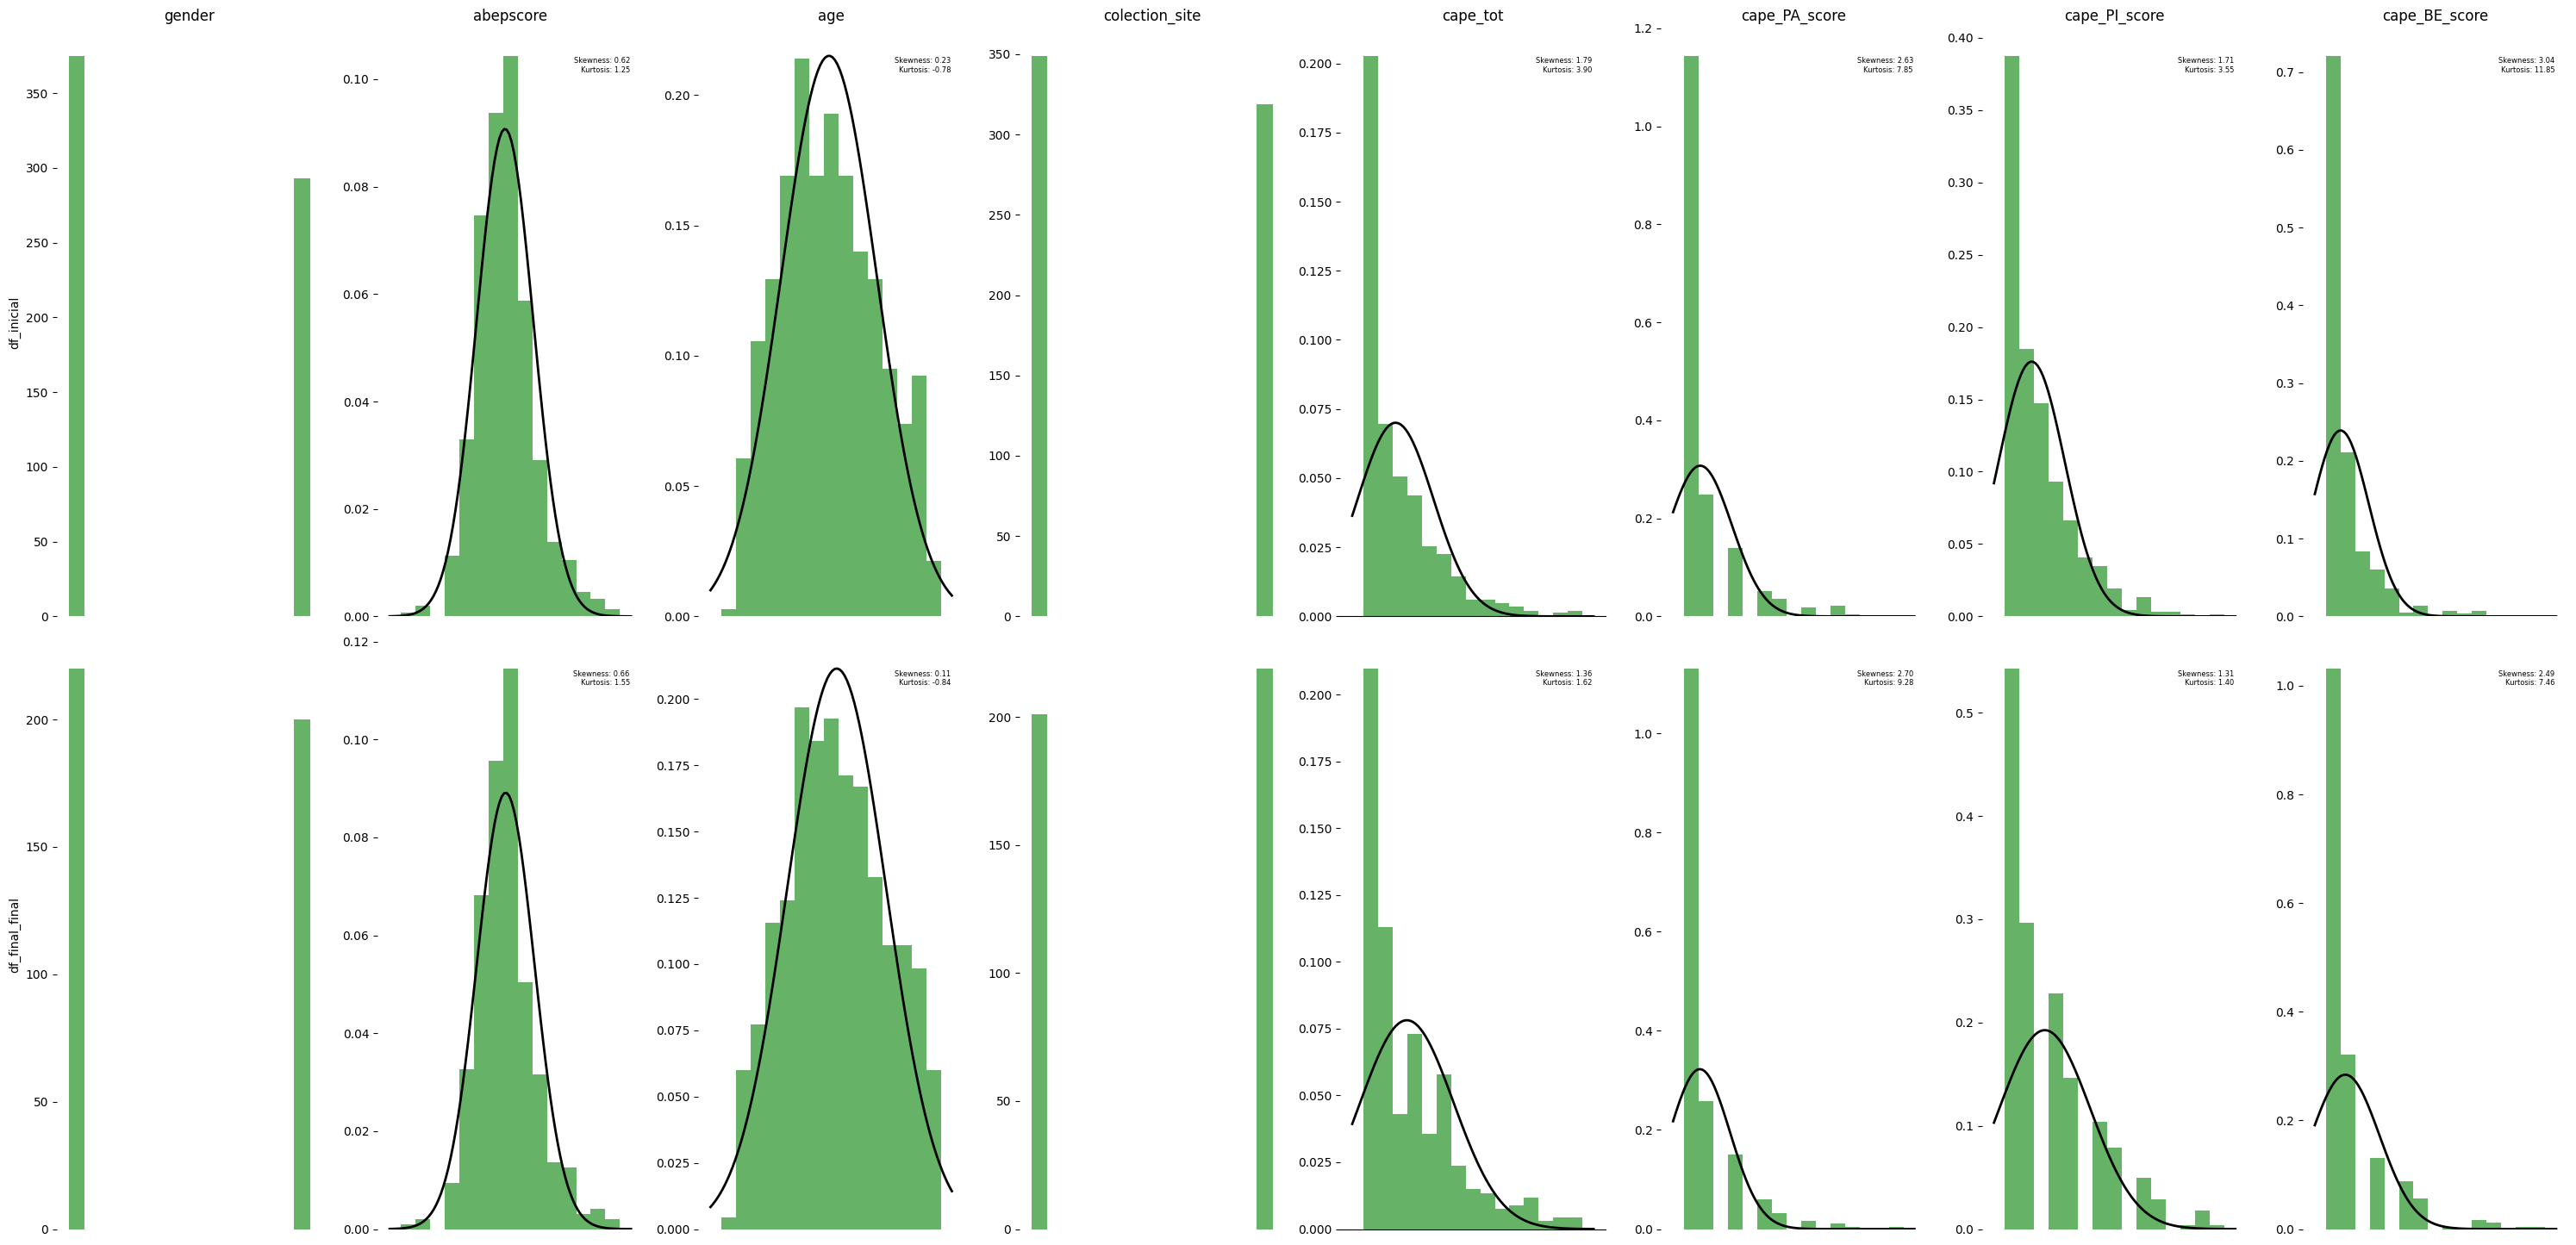

In [11]:
# Definir a figura
plt.figure(figsize=(30,15))

# Lista de títulos para cada DataFrame
titles = ['df_inicial','df_final_final']

# Variáveis categóricas
variables_categ = ['gender', 'colection_site']

# Iterar sobre os DataFrames e adicionar os gráficos
for idf, data_frame in enumerate([df_inicial, df_final_final]):
    for indexx, var in enumerate(['gender', 'abepscore', 'age', 'colection_site', 'cape_tot', 'cape_PA_score', 'cape_PI_score', 'cape_BE_score']):
        
        # Subplot: 5 linhas, 10 colunas
        plt.subplot(2, 8, 8*idf + indexx+1)

        # Obter os dados da variável atual, removendo NaNs
        data = data_frame[var].dropna()

        # Verificar se a variável é categórica
        if var in variables_categ:
            # Plotar apenas o histograma para variáveis categóricas
            plt.hist(data, bins=15, alpha=0.6, color='g', label='Histograma')
            if idf == 0:   
                plt.title(f'{var}', fontsize=12)
        else:
            # Para variáveis contínuas, calcular a média e o desvio padrão
            mean = np.mean(data)
            std = np.std(data)

            # Plotar o histograma da variável
            plt.hist(data, bins=15, density=True, alpha=0.6, color='g', label='Histograma')

            # Gerar uma linha de normalidade (curva normal)
            xmin, xmax = plt.xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mean, std)
            plt.plot(x, p, 'k', linewidth=2, label='Curva Normal')
            if idf == 0:   
                plt.title(f'{var}', fontsize=12)

            # Calcular skewness (assimetria) e kurtosis (curtose)
            skewness = skew(data)
            kurt = kurtosis(data)

            # Adicionar os valores de skewness e kurtosis no plot
            plt.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', 
                     transform=plt.gca().transAxes, fontsize=6, verticalalignment='top', horizontalalignment='right')

        # Adicionar o nome do eixo Y apenas para o primeiro gráfico de cada linha
        if indexx == 0:
            plt.ylabel(titles[idf], fontsize=10)

        # Remover o eixo vertical e os valores do gráfico
        plt.gca().axes.get_xaxis().set_visible(False)  # Esconde o eixo Y
        plt.gca().spines['left'].set_visible(False)    # Remove a linha do eixo Y
        plt.gca().spines['right'].set_visible(False)   # Remove a linha do eixo Y
        plt.gca().spines['top'].set_visible(False)     # Remove a linha do eixo superior
        plt.gca().spines['bottom'].set_visible(False)  # Remove a linha do eixo inferior
        if var =='cape_tot':
            plt.gca().spines['bottom'].set_visible(True)  # Remove a linha do eixo inferior



# Ajustar o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Deixar espaço no topo para os títulos
plt.show()


In [12]:
# Lista de DataFrames
dfs = [df_inicial, df_final_final]
dfs_name = ['df_inicial', 'df_final_final']

# Lista de variáveis que você quer comparar
variables_conti = ['abepscore', 'age', 'cape_tot', 'cape_PA_score', 'cape_PI_score', 'cape_BE_score', 'fd_count_high_value']
variables_categ = ['gender', 'colection_site']

# Função para rodar teste de permutação para variáveis contínuas
def run_permutation_continuous(df1, df2, var, n_permutations=1000):
    # Coletar os valores dos DataFrames para a variável específica
    data1 = df1[var].dropna()
    data2 = df2[var].dropna()
    
    # Estatística observada (diferença de médias)
    observed_diff = np.mean(data1) - np.mean(data2)
    
    # Concatenar os dados
    combined = np.concatenate([data1, data2])
    
    # Inicializar lista para armazenar as diferenças permutadas
    perm_diffs = []
    
    # Realizar as permutações
    for _ in range(n_permutations):
        # Permutar os dados combinados
        permuted = np.random.permutation(combined)
        
        # Repartir os dados permutados
        perm_data1 = permuted[:len(data1)]
        perm_data2 = permuted[len(data1):]
        
        # Calcular a diferença de médias permutada
        perm_diff = np.mean(perm_data1) - np.mean(perm_data2)
        perm_diffs.append(perm_diff)
    
    # Calcular o valor-p
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
    
    return observed_diff, p_value

# Função para rodar teste de permutação para variáveis categóricas (Chi2 por permutação)
def run_permutation_categorical(df1, df2, var, n_permutations=1000):
    """
    Realiza um teste de permutação para a independência entre duas amostras
    e uma variável categórica, usando a estatística Chi-quadrado.

    Args:
        df1 (pd.DataFrame): O primeiro DataFrame representando o grupo 1.
        df2 (pd.DataFrame): O segundo DataFrame representando o grupo 2.
        var (str): O nome da variável categórica a ser testada.
        n_permutations (int): O número de permutações a serem realizadas.

    Returns:
        tuple: Uma tupla contendo a estatística Chi-quadrado observada
               e o valor-p do teste de permutação.
    """
    # 1. Preparar os dados para o teste
    # Coletar os valores da variável, removendo NaNs
    data1 = df1[var].dropna()
    data2 = df2[var].dropna()
    
    # Criar um array com todos os dados e seus respectivos rótulos de grupo
    combined_data = pd.concat([data1, data2])
    group_labels = np.array(['grupo1'] * len(data1) + ['grupo2'] * len(data2))
    
    # 2. Calcular a estatística Chi-quadrado observada
    # Criar a tabela de contingência observada
    observed_contingency_table = pd.crosstab(group_labels, combined_data)
    
    # Verificar se a tabela de contingência é válida (não vazia)
    if observed_contingency_table.size == 0 or 0 in observed_contingency_table.sum(axis=0).values:
        return None, "Dados insuficientes ou colunas vazias para cálculo de Chi-quadrado."
    
    # Calcular a estatística Chi-quadrado observada
    chi2_stat_observed, _, _, _ = stats.chi2_contingency(observed_contingency_table)
    
    # 3. Realizar as permutações
    chi2_stats_permuted = []
    for _ in range(n_permutations):
        # Permutar os rótulos de grupo (simulando a hipótese nula)
        permuted_labels = np.random.permutation(group_labels)
        
        # Criar a tabela de contingência permutada
        permuted_contingency_table = pd.crosstab(permuted_labels, combined_data)
        
        # Calcular a estatística Chi-quadrado permutada
        try:
            chi2_stat_perm, _, _, _ = stats.chi2_contingency(permuted_contingency_table)
            chi2_stats_permuted.append(chi2_stat_perm)
        except ValueError:
            # Lidar com casos onde a permutação resulta em uma tabela com uma única linha/coluna
            continue
    
    # 4. Calcular o valor-p
    if not chi2_stats_permuted:
        return None, "Não foi possível realizar permutações válidas."
    
    # O valor-p é a proporção de estatísticas permutadas que são
    # maiores ou iguais à estatística observada.
    p_value = np.mean(np.array(chi2_stats_permuted) >= chi2_stat_observed)
    
    return chi2_stat_observed, p_value

# Dicionário para armazenar os resultados
perm_conti_results = {}
perm_categ_results = {}

# Executar o teste de permutação para variáveis contínuas
for i in range(1, len(dfs)):  # Começar de 1 porque o primeiro DataFrame (df_final) é fixo
    df1 = dfs[0]  # df_final
    df_2 = dfs[i]  # Comparar com cada outro DataFrame

    # Armazenar resultados para cada variável contínua (permutação)
    for var in variables_conti:
        obs_diff, p_val = run_permutation_continuous(df1, df_2, var)
        perm_conti_results[f'{var}_{dfs_name[0]}_vs_{dfs_name[i]}'] = {"observed_diff": obs_diff, "p-value": p_val}

    # Armazenar resultados para cada variável categórica (permutação chi2)
    for var in variables_categ:
        chi2_stat, p_val = run_permutation_categorical(df1, df_2, var)
        if chi2_stat is not None and p_val is not None:
            perm_categ_results[f'{var}_{dfs_name[0]}_vs_{dfs_name[i]}'] = {"Chi2-statistic": chi2_stat, "p-value": p_val}

# Exibir os resultados de permutação para variáveis contínuas
print("\nPermutation Test Results (Continuous Variables):")
for var, result in perm_conti_results.items():
    print(f"Comparison: {var}")
    print(f"  Observed Difference: {result['observed_diff']}")
    print(f"  p-value: {result['p-value']}\n")

# Exibir os resultados do teste de permutação para variáveis categóricas
print("\nPermutation Test Results (Categorical Variables):")
for var, result in perm_categ_results.items():
    print(f"Comparison: {var}")
    print(f"  Chi2-statistic: {result['Chi2-statistic']}")
    print(f"  p-value: {result['p-value']}\n")




Permutation Test Results (Continuous Variables):
Comparison: abepscore_df_inicial_vs_df_final_final
  Observed Difference: -0.09716281722269926
  p-value: 0.731

Comparison: age_df_inicial_vs_df_final_final
  Observed Difference: -0.21306154679981937
  p-value: 0.073

Comparison: cape_tot_df_inicial_vs_df_final_final
  Observed Difference: 0.08929643929643927
  p-value: 0.807

Comparison: cape_PA_score_df_inicial_vs_df_final_final
  Observed Difference: 0.016044616044616045
  p-value: 0.829

Comparison: cape_PI_score_df_inicial_vs_df_final_final
  Observed Difference: 0.013663663663663783
  p-value: 0.915

Comparison: cape_BE_score_df_inicial_vs_df_final_final
  Observed Difference: 0.07687687687687683
  p-value: 0.412

Comparison: fd_count_high_value_df_inicial_vs_df_final_final
  Observed Difference: 15.051611063587112
  p-value: 0.0


Permutation Test Results (Categorical Variables):
Comparison: gender_df_inicial_vs_df_final_final
  Chi2-statistic: 1.3209663431757175
  p-value: 0.2

### Exporting

In [13]:
# df_final_final.to_excel(os.path.join(metadata_path,'variaveis_analise_conf_nova-exclusão.xlsx'))
# df_final_final.shape[0]

In [14]:
# summary statistics after imputation and quality control
print(df_final.describe())

           gender   abepscore         age          DQ  colection_site  \
count  593.000000  593.000000  593.000000  593.000000      593.000000   
mean     1.445194   18.308600    9.978353  102.667791        1.483980   
std      0.497407    4.394892    1.832377   15.768787        0.500165   
min      1.000000    2.000000    5.831622   71.000000        1.000000   
25%      1.000000   15.000000    8.594114   91.000000        1.000000   
50%      1.000000   18.000000    9.883641  100.000000        1.000000   
75%      2.000000   21.000000   11.277207  112.000000        2.000000   
max      2.000000   36.000000   14.173854  152.000000        2.000000   

         cape_tot  cape_PA_score  cape_PI_score  cape_BE_score  fd_mean_value  \
count  593.000000     593.000000     593.000000     593.000000     593.000000   
mean     4.644182       0.617201       1.765599       0.812816       0.213436   
std      5.333779       1.231693       2.164837       1.539032       0.236179   
min      0.000000 

# extra code

In [15]:
# Idependent code for extracting the data from the selected neurimage cohort subjects
import os, sys
print('python version:',sys.version)
import pandas as pd
print('pandas version:',pd.__version__)
import openpyxl
print('openpyxl version:',openpyxl.__version__)

#set the root environment the previous folder
# currFile = os.path.abspath('__file__')
dname = os.path.dirname(os.path.abspath('__file__'))
os.environ["ROOTDIR"] = dname  # seth path
print('root enviorment:',os.environ["ROOTDIR"])

data = os.path.join(os.environ["ROOTDIR"], 'data')
print("data folder:",data)

img_cohort = pd.read_excel(os.path.join(data,'idade-neuro.xlsx'))
# changing the ident to sub_id
for index in img_cohort['ident']:  
    img_cohort['ident'] = img_cohort['ident'].replace(index, 'sub-{}'.format(str(int(index)).zfill(5)))
img_cohort = img_cohort.rename(columns={'ident':'sub_id'})

#dropping all subjects having neuro != 1
img_cohort = img_cohort.query('neuro == 1')
print(img_cohort.head(), '\nshape =',img_cohort.shape)

print("------------------------------------------ uploading the full data set for comparison -------------------------------------")
pd.read_csv(os.path.join(data,'banco_carola.csv')).head()

python version: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas version: 1.3.5
openpyxl version: 3.1.3
root enviorment: c:\Users\angel\Documents\masters-uploaded-github\INPD-neuroimage-cape\code
data folder: c:\Users\angel\Documents\masters-uploaded-github\INPD-neuroimage-cape\code\data


FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\angel\\Documents\\masters-uploaded-github\\INPD-neuroimage-cape\\code\\data\\idade-neuro.xlsx'